ATML Project


In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import os
import codecs


Bad key "text.kerning_factor" on line 4 in
C:\Users\Bohne\Anaconda3\envs\scheduleenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
#function for reading a csv
def read_csv(filename):
    #takes a absolute or relative path of a .csv file and returns a pd dateframe
    #problems occured: pd.read_csv did not worked: no encoding like utf-8 could decode byte 0x97 in position 5472
    
    
    with open(filename, newline='') as csvfile:
        #stores words in a csv.reader object
        reader = csv.reader(csvfile, delimiter=';')
        #init empty list
        l=[]
        #it thrue rows of reader
        for row in reader:
            #append each row (first converted to numpy array) to list
            l.append(np.array(row))
    #convert list to numpy array
    l=np.array(l)
    #return a Dataframe where the column names are the first row of the numpy array and the rest is the data
    return pd.DataFrame(l[1:],columns=l[0])



      


In [3]:
#display label dataframe with the information of the books
info_df=read_csv('data/Gutenberg_English_Fiction_1k/master996.csv')
#data = pd.read_csv("data/Gutenberg_English_Fiction_1k/master996.csv", encoding= 'unicode_escape')
#print(info_df.head())
print(info_df)

                                             Book_Name  \
0    The Mystery of the Boule Cabinet: A Detective ...   
1                                            The Pupil   
2                                       At Love's Cost   
3                               The Heart of the Range   
4                          The Worshipper of the Image   
..                                                 ...   
991                                  David Copperfield   
992                                         Hard Times   
993                          Memoirs of Shelock Holmes   
994                    The Mysterious Affair at Styles   
995                               A Tale of Two Cities   

                          book_id            guten_genre  \
0                    pg10067.epub  Detective and Mystery   
1                     pg1032.epub               Literary   
2                    pg10379.epub               Literary   
3                    pg10473.epub        Western Stories   
4  

In [4]:
#some informations of the data set
genres,cnts=np.unique(info_df['guten_genre'],return_counts=True)
print('Genres:',genres)
print(cnts)


Genres: ['Allegories' 'Christmas Stories' 'Detective and Mystery'
 'Ghost and Horror' 'Humorous and Wit and Satire' 'Literary'
 'Love and Romance' 'Sea and Adventure' 'Western Stories']
[  2   5 111   6   6 794  18  36  18]


In [5]:
#parse html files
b_id=info_df['book_id']

book_l=list(map(lambda x: x.replace('.epub','-content.html'),b_id))

gb_book=[]
for book in book_l:
    f=codecs.open('data/Gutenberg_English_Fiction_1k/Gutenberg_19th_century_English_Fiction/'+book,'r','utf-8')
    doc=f.read().replace('<p>','')
    gb_book.append([book.replace('-content.html','.epub'),doc])
#generate dataframe with book_id and content
book_pd=pd.DataFrame(gb_book,columns=['book_id','content'])


In [6]:
print(book_pd.head())

        book_id                                            content
0  pg10067.epub  A Detective Story\nA.B.M. Fellow-Sherlockian\n...
1   pg1032.epub  This edition first published 1916\nThe text fo...
2  pg10379.epub  "Until this moment I have never fully realised...
3  pg10473.epub  "The Rider of Golden Bar," "Hidden Trails," "L...
4  pg10812.epub  The Worshipper of the Image\nEvening was in th...


In [7]:
print(info_df['guten_genre'].value_counts())
print(len(book_pd.loc[0]['content']))

Literary                       794
Detective and Mystery          111
Sea and Adventure               36
Western Stories                 18
Love and Romance                18
Humorous and Wit and Satire      6
Ghost and Horror                 6
Christmas Stories                5
Allegories                       2
Name: guten_genre, dtype: int64
371350


In [8]:
#first shot https://www.kaggle.com/yufengdev/bbc-text-categorization
import os
import itertools
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow import keras
layers = keras.layers
models = keras.models
print("You have TensorFlow version", tf.__version__)

C:\Users\Bohne\AppData\Roaming\Python\Python37\site-packages\requests\__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.8) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


You have TensorFlow version 2.1.0


In [9]:
train_size = int(len(info_df) * .8)

In [10]:
train_text,test_text,train_cat,test_cat=train_test_split(np.array(book_pd['content']),np.array(info_df['guten_genre']), test_size=0.2)

max_words =10000
tokenize = keras.preprocessing.text.Tokenizer(num_words=max_words, 
                                              char_level=False)

In [11]:
tokenize.fit_on_texts(train_text) # fit tokenizer to our training text data
x_train = tokenize.texts_to_matrix(train_text)
x_test = tokenize.texts_to_matrix(test_text)

In [12]:

# Use sklearn utility to convert label strings to numbered index
encoder = LabelEncoder()
encoder.fit(train_cat)

y_train = encoder.transform(train_cat)
y_test = encoder.transform(test_cat)

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

In [13]:
# Converts the labels to a one-hot representation
num_classes = np.max(y_train) + 1
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [14]:
# Inspect the dimenstions of our training and test data (this is helpful to debug)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (796, 10000)
x_test shape: (200, 10000)
y_train shape: (796, 9)
y_test shape: (200, 9)


In [27]:
# This model trains very quickly and 2 epochs are already more than enough
# Training for more epochs will likely lead to overfitting on this dataset
# You can try tweaking these hyperparamaters when using this model with your own data
batch_size = 32
epochs = 2
drop_ratio = 0.5

In [28]:
# Build the model
model = models.Sequential()
model.add(layers.Dense(512, input_shape=(max_words,)))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(drop_ratio))
model.add(layers.Dense(num_classes))
model.add(layers.Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [29]:
# model.fit trains the model
# The validation_split param tells Keras what % of our training data should be used in the validation set
# You can see the validation loss decreasing slowly when you run this
# Because val_loss is no longer decreasing we stop training to prevent overfitting
print(class_weights)
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,class_weight=class_weights)

[88.44444444 44.22222222  1.00505051 17.68888889 17.68888889  0.13928259
  7.37037037  2.85304659  5.20261438]
Train on 716 samples, validate on 80 samples
Epoch 1/2
716/716 [==============================] - 1s 861us/sample - loss: 4.8966 - accuracy: 0.6494 - val_loss: 1.4174 - val_accuracy: 0.8625
Epoch 2/2
716/716 [==============================] - 0s 151us/sample - loss: 1.2136 - accuracy: 0.7807 - val_loss: 1.0364 - val_accuracy: 0.8625


In [30]:
#get baseline
y_bl=np.zeros(y_test.shape[0])+5
y_bl = keras.utils.to_categorical(y_bl, num_classes)
m=tf.keras.metrics.Accuracy()
print(np.unique(y_test,return_counts=True))
_ = m.update_state(y_test, y_bl) 
m.result().numpy()

(array([0., 1.], dtype=float32), array([1600,  200], dtype=int64))


0.95444447

In [26]:
# Evaluate the accuracy of our trained model
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
from sklearn.metrics import classification_report

ypred = model.predict(x_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(ypred, axis=1)
y_test_bool= np.argmax(y_test, axis=1)
print(np.unique(y_test_bool,return_counts=True),'\n\n')
print(classification_report(y_test_bool, y_pred_bool))

200/200 [==============================] - 0s 125us/sample - loss: 0.6259 - accuracy: 0.8650
Test loss: 0.6258658730983734
Test accuracy: 0.865
200/200 [==============================] - 0s 180us/sample
(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64), array([  1,   3,  23,   1,   1, 159,   6,   5,   1], dtype=int64)) 


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         3
           2       0.94      0.65      0.77        23
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.86      0.99      0.92       159
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00         5
           8       0.00      0.00      0.00         1

    accuracy                           0.86       200
   macro avg       0.20      0.18      0.19       200
weighted avg       0.79    

C:\Users\Bohne\Anaconda3\envs\scheduleenv\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
y_softmax = model.predict(x_test)
# Here's how to generate a prediction on individual examples
text_labels = encoder.classes_ 
y_test_1d = []
y_pred_1d = []

for i in range(len(y_test)):
    probs = y_test[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

In [21]:
# This utility function is from the sklearn docs: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

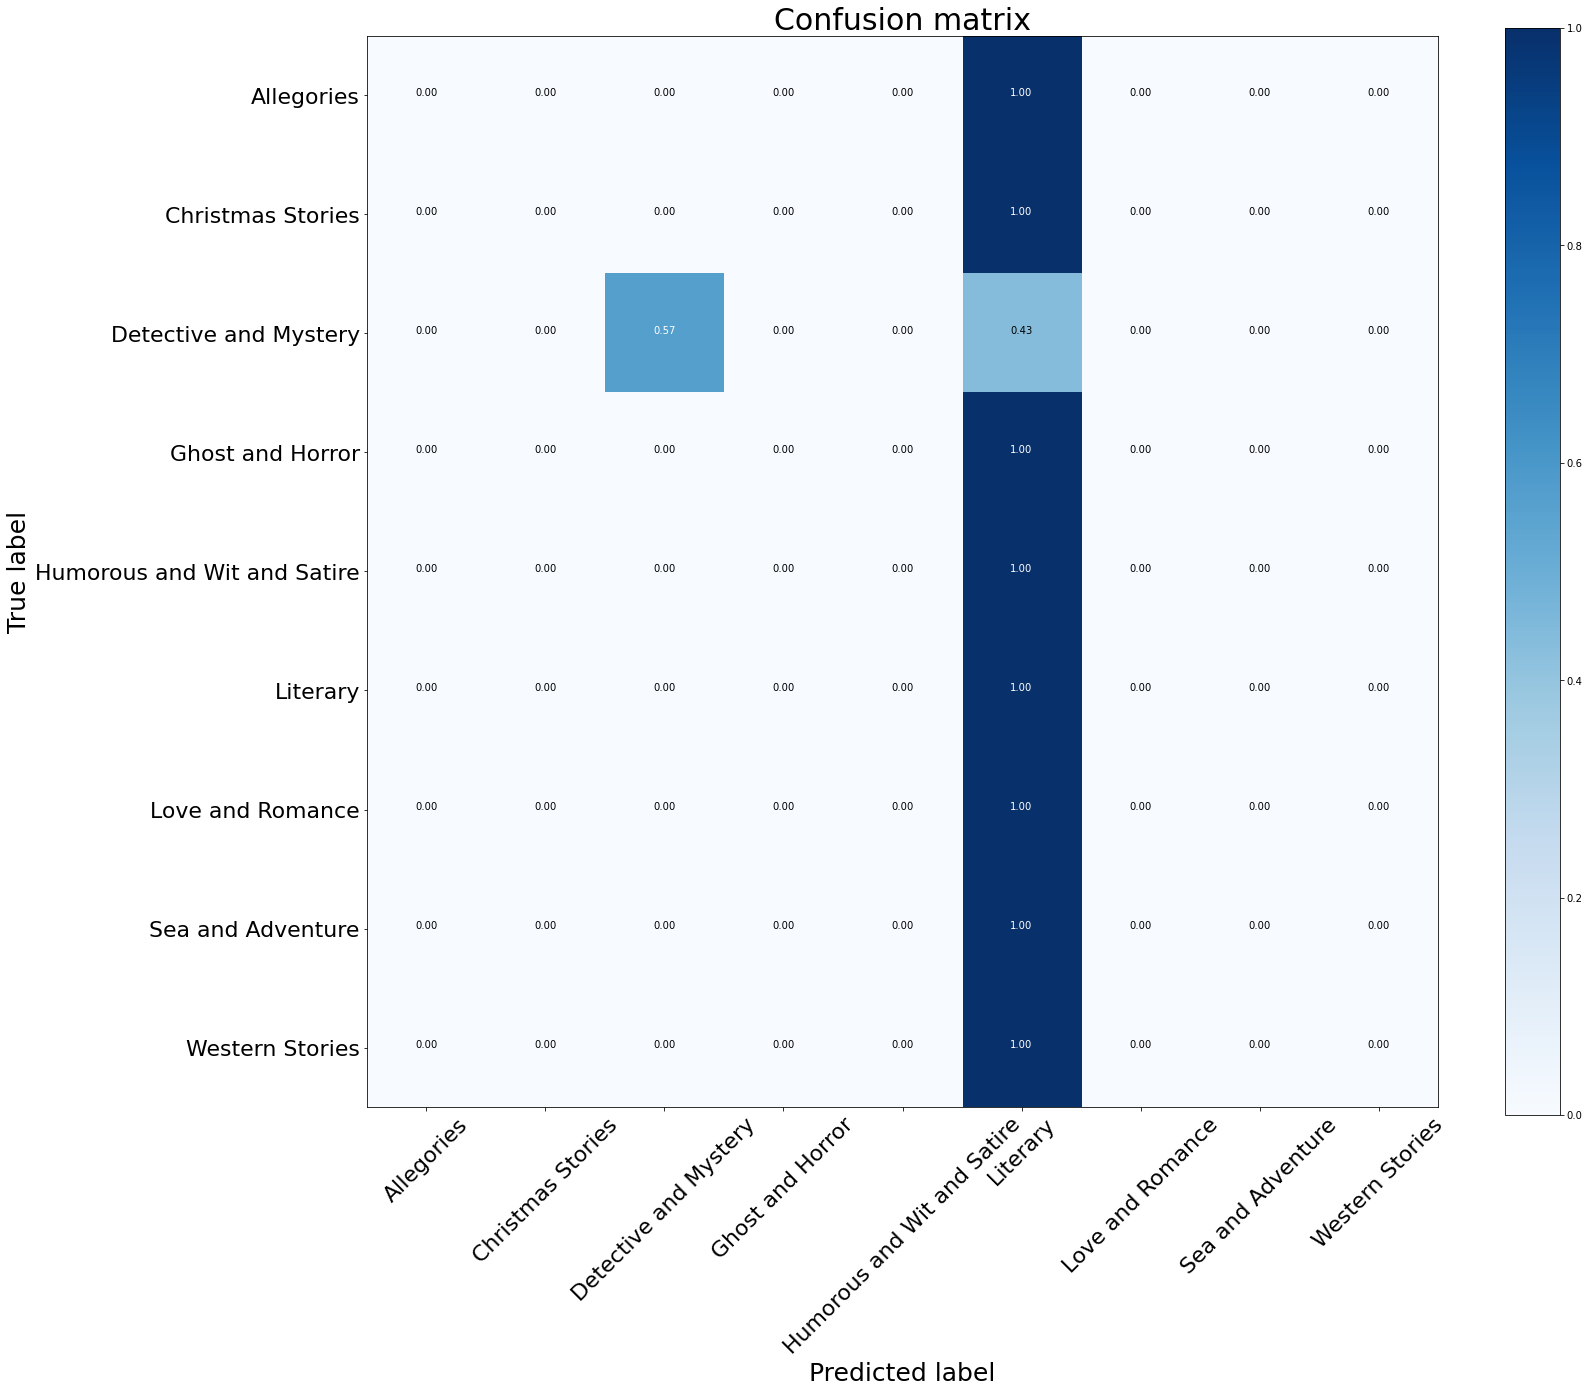

In [22]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(24,20))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()